In [1]:
import sys
import logging
import numpy as np
import pandas as pd
import datetime as dt
from os.path import isfile
from pandas import DateOffset
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.forecasting.theta import ThetaModel
from service import generate_features
from data.db_model import InfluxDBModel
from datetime import datetime, timedelta
from data.binance_ import get_binance_historical_klines
from models.predictive import sarimax_train_predict, xgboost_train, xgboost_predict
from models.utils import ADF_criteria, split_time, freq_to_tick, train_features_split
from models.utils import load_results, store_results, align_train_start, align_predict_interval
import datetime
from datetime import datetime, timedelta

Dounload the data

In [2]:
scalping_btc = pd.read_csv('BTCUSDT_15m_12h_backtest.csv', index_col='bought')
scalping_btc

,Unnamed: 0,buy_price,stop_loss,sold,sell_price,stoped
bought,,,,,,
2018-09-03 14:14:00+00:00,0,7280.437150,7220.799542,2018-09-04 12:02:00+00:00,7358.004144,False
2018-09-05 00:21:00+00:00,1,7355.924259,7307.741910,2018-09-05 09:51:00+00:00,7307.741910,True
2018-09-05 15:48:00+00:00,2,6960.700320,6746.407562,2018-09-05 23:46:00+00:00,6746.407562,True
2018-09-06 00:17:00+00:00,3,6623.449690,6418.237222,2018-09-06 03:24:00+00:00,6418.237222,True
2018-09-06 14:39:00+00:00,4,6455.386604,6242.634624,2018-09-06 23:45:00+00:00,6533.764829,False
...,...,...,...,...,...,...
2021-11-25 14:06:00+00:00,1345,58467.229238,57953.298811,2021-11-26 03:54:00+00:00,57953.298811,True
2021-11-26 21:51:00+00:00,1346,54054.952066,53137.830544,2021-11-27 08:11:00+00:00,54683.382693,False
2021-11-27 14:19:00+00:00,1347,54958.320235,54226.628659,2021-11-27 20:54:00+00:00,54226.628659,True


In [3]:
scalping_btc = scalping_btc.set_index(pd.to_datetime(scalping_btc.index))

In [4]:
scalping_btc

,Unnamed: 0,buy_price,stop_loss,sold,sell_price,stoped
bought,,,,,,
2018-09-03 14:14:00+00:00,0,7280.437150,7220.799542,2018-09-04 12:02:00+00:00,7358.004144,False
2018-09-05 00:21:00+00:00,1,7355.924259,7307.741910,2018-09-05 09:51:00+00:00,7307.741910,True
2018-09-05 15:48:00+00:00,2,6960.700320,6746.407562,2018-09-05 23:46:00+00:00,6746.407562,True
2018-09-06 00:17:00+00:00,3,6623.449690,6418.237222,2018-09-06 03:24:00+00:00,6418.237222,True
2018-09-06 14:39:00+00:00,4,6455.386604,6242.634624,2018-09-06 23:45:00+00:00,6533.764829,False
...,...,...,...,...,...,...
2021-11-25 14:06:00+00:00,1345,58467.229238,57953.298811,2021-11-26 03:54:00+00:00,57953.298811,True
2021-11-26 21:51:00+00:00,1346,54054.952066,53137.830544,2021-11-27 08:11:00+00:00,54683.382693,False
2021-11-27 14:19:00+00:00,1347,54958.320235,54226.628659,2021-11-27 20:54:00+00:00,54226.628659,True


In [5]:
FEE = 0.0002
scalping_btc['gross_pnl'] = scalping_btc['sell_price']  / scalping_btc['buy_price'] - 1
scalping_btc['profit'] = (scalping_btc['sell_price'] - scalping_btc['sell_price'] * FEE * 2)  / scalping_btc['buy_price']  - 1

In [6]:
scalping_btc

,Unnamed: 0,buy_price,stop_loss,sold,sell_price,stoped,gross_pnl,profit
bought,,,,,,,,
2018-09-03 14:14:00+00:00,0,7280.437150,7220.799542,2018-09-04 12:02:00+00:00,7358.004144,False,0.010654,0.010250
2018-09-05 00:21:00+00:00,1,7355.924259,7307.741910,2018-09-05 09:51:00+00:00,7307.741910,True,-0.006550,-0.006948
2018-09-05 15:48:00+00:00,2,6960.700320,6746.407562,2018-09-05 23:46:00+00:00,6746.407562,True,-0.030786,-0.031174
2018-09-06 00:17:00+00:00,3,6623.449690,6418.237222,2018-09-06 03:24:00+00:00,6418.237222,True,-0.030983,-0.031370
2018-09-06 14:39:00+00:00,4,6455.386604,6242.634624,2018-09-06 23:45:00+00:00,6533.764829,False,0.012142,0.011737
...,...,...,...,...,...,...,...,...
2021-11-25 14:06:00+00:00,1345,58467.229238,57953.298811,2021-11-26 03:54:00+00:00,57953.298811,True,-0.008790,-0.009187
2021-11-26 21:51:00+00:00,1346,54054.952066,53137.830544,2021-11-27 08:11:00+00:00,54683.382693,False,0.011626,0.011221
2021-11-27 14:19:00+00:00,1347,54958.320235,54226.628659,2021-11-27 20:54:00+00:00,54226.628659,True,-0.013314,-0.013708


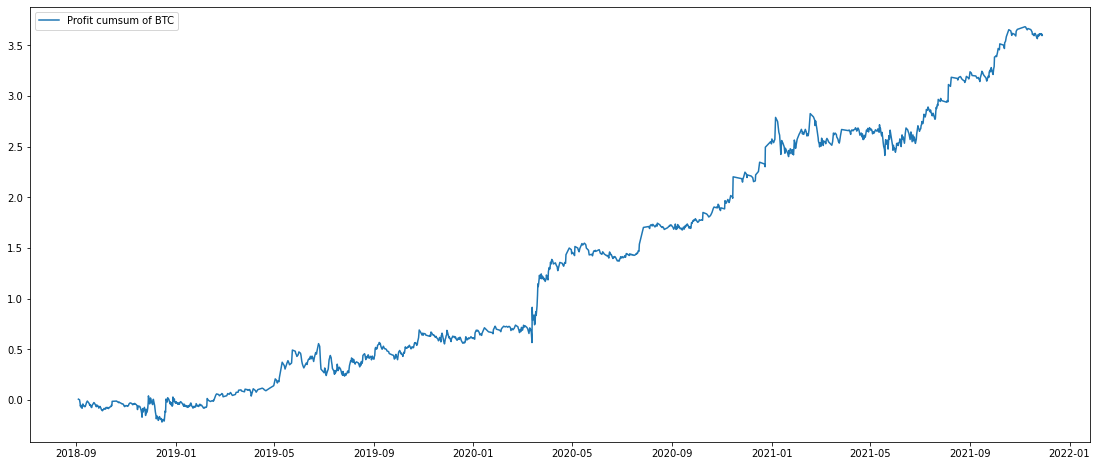

In [7]:
plt.figure(figsize=(19, 8))
plt.plot(scalping_btc['profit'].cumsum(), label='Profit cumsum of BTC')
plt.legend()

In [8]:
def analysis_metrics (df, period = pd.Timedelta(days=7)):
    start = df.index[0]
    end = start + period
    metrics = []
    while end < df.index[-1]:
        cur_week = df[start.strftime("%Y-%m-%dT%H:%M:%S"):end.strftime("%Y-%m-%dT%H:%M:%S")]
        positive_trades = cur_week[cur_week['profit'] > 0]
        negative_trades = cur_week[cur_week['profit'] < 0]
        
        sum_pozitive = positive_trades['profit'].sum()
        sum_negative = negative_trades['profit'].sum()
        
        mean_positive = positive_trades['profit'].mean()
        mean_negative = negative_trades['profit'].mean()
        
        row = {
            "datetime": end,
            'sum positive': sum_pozitive,
            'sum negative' : sum_negative,
            'mean positive' : mean_positive,
            'mean negative' : mean_negative,
            'risk to reward' :  mean_positive / abs(mean_negative),
            'win rate' : len(positive_trades) / (len(cur_week['profit']) + 0.001)
        }
        metrics.append(row)
        start += period
        end += period
    
    return metrics
        

In [9]:
analysis = analysis_metrics (scalping_btc)
analysis

[{'datetime': Timestamp('2018-09-10 14:14:00+0000', tz='UTC'),
  'sum positive': 0.07200133782329332,
  'sum negative': -0.12465629500417008,
  'mean positive': 0.014400267564658665,
  'mean negative': -0.02077604916736168,
  'risk to reward': 0.6931186698999968,
  'win rate': 0.4545041359876375},
 {'datetime': Timestamp('2018-09-17 14:14:00+0000', tz='UTC'),
  'sum positive': 0.05640023475530209,
  'sum negative': -0.05495344893211007,
  'mean positive': 0.011280046951060418,
  'mean negative': -0.010990689786422014,
  'risk to reward': 1.0263274799181283,
  'win rate': 0.4999500049995001},
 {'datetime': Timestamp('2018-09-24 14:14:00+0000', tz='UTC'),
  'sum positive': 0.057723903791304876,
  'sum negative': -0.0464632113610608,
  'mean positive': 0.011544780758260976,
  'mean negative': -0.00929264227221216,
  'risk to reward': 1.24235717033716,
  'win rate': 0.4999500049995001},
 {'datetime': Timestamp('2018-10-01 14:14:00+0000', tz='UTC'),
  'sum positive': 0.03825629813714726,
  

In [10]:
analysis = pd.DataFrame(analysis)
analysis = analysis.set_index('datetime', drop=True)
analysis

,sum positive,sum negative,mean positive,mean negative,risk to reward,win rate
datetime,,,,,,
2018-09-10 14:14:00+00:00,0.072001,-0.124656,0.014400,-0.020776,0.693119,0.454504
2018-09-17 14:14:00+00:00,0.056400,-0.054953,0.011280,-0.010991,1.026327,0.499950
2018-09-24 14:14:00+00:00,0.057724,-0.046463,0.011545,-0.009293,1.242357,0.499950
2018-10-01 14:14:00+00:00,0.038256,-0.084994,0.009564,-0.010624,0.900215,0.333306
2018-10-08 14:14:00+00:00,0.043097,-0.027647,0.008619,-0.006912,1.247088,0.555494
...,...,...,...,...,...,...
2021-10-25 14:14:00+00:00,0.019957,-0.065677,0.019957,-0.016419,1.215466,0.199960
2021-11-01 14:14:00+00:00,0.065562,-0.016750,0.032781,-0.016750,1.957093,0.666445
2021-11-08 14:14:00+00:00,0.026487,-0.007065,0.026487,-0.007065,3.748963,0.499750


In [11]:
analysis['mean positive'] = analysis['mean positive'].fillna(0)
analysis['risk to reward'] = analysis['risk to reward'].fillna(0)

In [12]:
analysis

,sum positive,sum negative,mean positive,mean negative,risk to reward,win rate
datetime,,,,,,
2018-09-10 14:14:00+00:00,0.072001,-0.124656,0.014400,-0.020776,0.693119,0.454504
2018-09-17 14:14:00+00:00,0.056400,-0.054953,0.011280,-0.010991,1.026327,0.499950
2018-09-24 14:14:00+00:00,0.057724,-0.046463,0.011545,-0.009293,1.242357,0.499950
2018-10-01 14:14:00+00:00,0.038256,-0.084994,0.009564,-0.010624,0.900215,0.333306
2018-10-08 14:14:00+00:00,0.043097,-0.027647,0.008619,-0.006912,1.247088,0.555494
...,...,...,...,...,...,...
2021-10-25 14:14:00+00:00,0.019957,-0.065677,0.019957,-0.016419,1.215466,0.199960
2021-11-01 14:14:00+00:00,0.065562,-0.016750,0.032781,-0.016750,1.957093,0.666445
2021-11-08 14:14:00+00:00,0.026487,-0.007065,0.026487,-0.007065,3.748963,0.499750


In [13]:
analysis['risk to reward'].ewm(span=100).mean()[-50:]

datetime
2020-12-14 14:14:00+00:00    2.064384
2020-12-21 14:14:00+00:00    2.019428
2020-12-28 14:14:00+00:00    2.163173
2021-01-04 14:14:00+00:00    2.154790
2021-01-11 14:14:00+00:00    2.172444
2021-01-18 14:14:00+00:00    2.176671
2021-01-25 14:14:00+00:00    2.173978
2021-02-01 14:14:00+00:00    2.172224
2021-02-08 14:14:00+00:00    2.152855
2021-02-15 14:14:00+00:00    2.148339
2021-02-22 14:14:00+00:00    2.213694
2021-03-01 14:14:00+00:00    2.193038
2021-03-08 14:14:00+00:00    2.205196
2021-03-15 14:14:00+00:00    2.175902
2021-03-22 14:14:00+00:00    2.183832
2021-03-29 14:14:00+00:00    2.183929
2021-04-05 14:14:00+00:00    2.137568
2021-04-12 14:14:00+00:00    2.112892
2021-04-19 14:14:00+00:00    2.092374
2021-04-26 14:14:00+00:00    2.069535
2021-05-03 14:14:00+00:00    2.059277
2021-05-10 14:14:00+00:00    2.038793
2021-05-17 14:14:00+00:00    2.022811
2021-05-24 14:14:00+00:00    2.006852
2021-05-31 14:14:00+00:00    1.993598
2021-06-07 14:14:00+00:00    1.975403
202

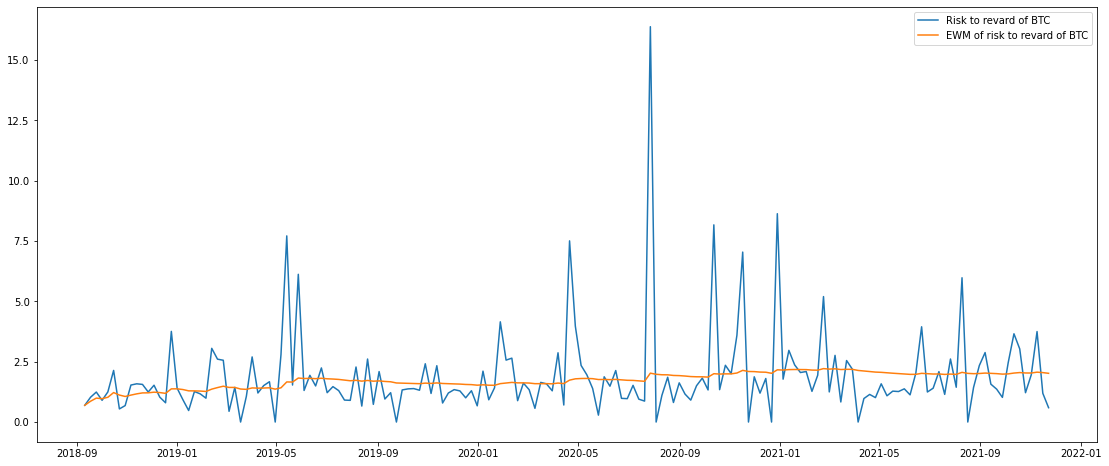

In [14]:
plt.figure(figsize=(19, 8))
plt.plot(analysis['risk to reward'], label='Risk to revard of BTC')
plt.plot(analysis['risk to reward'].ewm(span=100).mean(), label='EWM of risk to revard of BTC')
plt.legend()

In [15]:
analysis

,sum positive,sum negative,mean positive,mean negative,risk to reward,win rate
datetime,,,,,,
2018-09-10 14:14:00+00:00,0.072001,-0.124656,0.014400,-0.020776,0.693119,0.454504
2018-09-17 14:14:00+00:00,0.056400,-0.054953,0.011280,-0.010991,1.026327,0.499950
2018-09-24 14:14:00+00:00,0.057724,-0.046463,0.011545,-0.009293,1.242357,0.499950
2018-10-01 14:14:00+00:00,0.038256,-0.084994,0.009564,-0.010624,0.900215,0.333306
2018-10-08 14:14:00+00:00,0.043097,-0.027647,0.008619,-0.006912,1.247088,0.555494
...,...,...,...,...,...,...
2021-10-25 14:14:00+00:00,0.019957,-0.065677,0.019957,-0.016419,1.215466,0.199960
2021-11-01 14:14:00+00:00,0.065562,-0.016750,0.032781,-0.016750,1.957093,0.666445
2021-11-08 14:14:00+00:00,0.026487,-0.007065,0.026487,-0.007065,3.748963,0.499750


In [16]:
scalping_btc['profit'].sum()

3.5978450125817205

In [17]:
scalping_btc['profit'].mean()

0.0026650703796901633

In [18]:
scalping_btc[scalping_btc['profit'] < 0].profit.sum()

-12.460405121929075

In [19]:
scalping_btc[scalping_btc['profit'] > 0].profit.sum()

16.058250134510793

In [20]:
scalping_btc[scalping_btc['profit']>0].profit.sum()/len(scalping_btc[scalping_btc['profit']>0])

0.026455107305619098

In [21]:
scalping_btc[scalping_btc['profit']<0].profit.sum()/len(scalping_btc[scalping_btc['profit']<0])

-0.01677039720313469

In [22]:
len(scalping_btc[scalping_btc['profit']>0])/len(scalping_btc['profit'])

0.44962962962962966

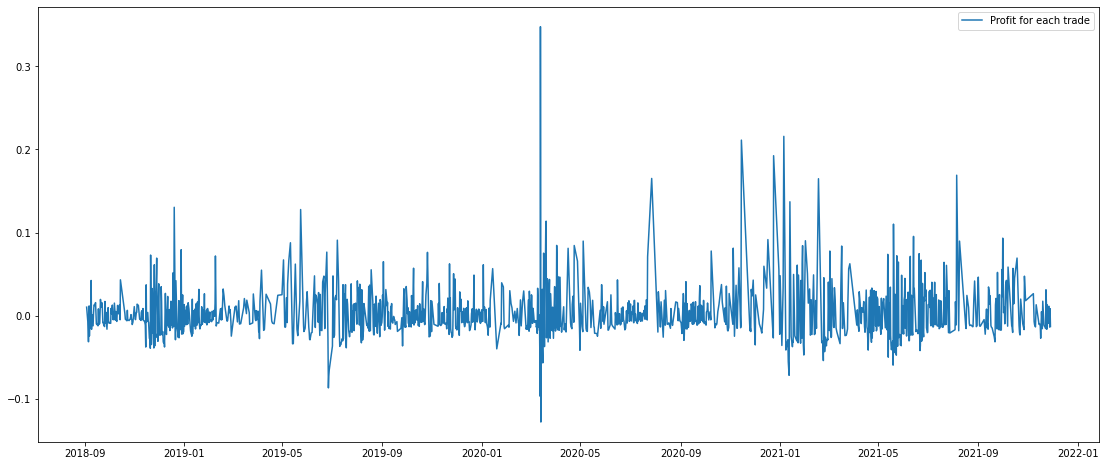

In [23]:
plt.figure(figsize=(19, 8))
plt.plot(scalping_btc['profit'], label='Profit for each trade')
plt.legend()

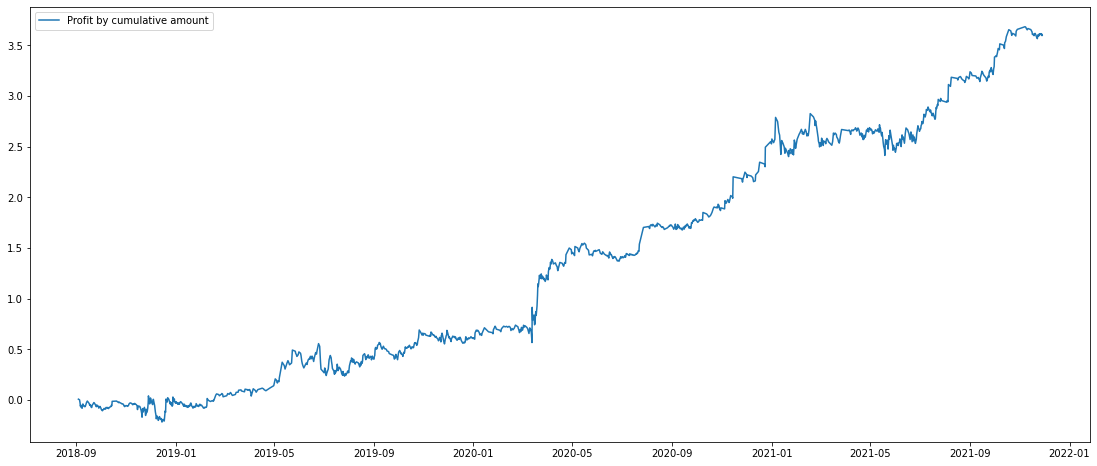

In [24]:
plt.figure(figsize=(19, 8))
plt.plot(scalping_btc['profit'].cumsum(), label='Profit by cumulative amount')
plt.legend()